# Model training and Evaluation

In [ ]:
 %run adversarial_model_training.ipynb

Using available GPUs:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Train count: 128116
Validation count: 25000
Test count: 25000
Loaded 298 TFrecord train files
Loaded 59 TFrecord validation files
Loaded 59 TFrecord test files
Training robust ResNet-50 model...

Phase 1: Training classification head...
Epoch 1/10
    856/Unknown 549s 633ms/step - accuracy: 0.3662 - loss: 4.0234

/Users/stanleyokwii/Documents/Birkbeck/Msc Project/msc-project-source-code-files-24-25-Stanley-Okwii/.venv/lib/python3.12/site-packages/keras/src/trainers/epoch_iterator.py:164: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 1: val_accuracy improved from None to 0.58914, saving model to ../datasets/models/best_robust_resnet50_phase1.keras
856/856 ━━━━━━━━━━━━━━━━━━━━ 658s 761ms/step - accuracy: 0.5109 - loss: 2.7714 - val_accuracy: 0.5891 - val_loss: 2.1214 - learning_rate: 0.0010
Epoch 2/10
856/856 ━━━━━━━━━━━━━━━━━━━━ 0s 626ms/step - accuracy: 0.6058 - loss: 1.9856
Epoch 2: val_accuracy improved from 0.58914 to 0.60360, saving model to ../datasets/models/best_robust_resnet50_phase1.keras
856/856 ━━━━━━━━━━━━━━━━━━━━ 647s 752ms/step - accuracy: 0.6203 - loss: 1.9113 - val_accuracy: 0.6036 - val_loss: 2.0528 - learning_rate: 9.6000e-04
Epoch 3/10
856/856 ━━━━━━━━━━━━━━━━━━━━ 0s 632ms/step - accuracy: 0.6212 - loss: 1.8887
Epoch 3: val_accuracy improved from 0.60360 to 0.61192, saving model to ../datasets/models/best_robust_resnet50_phase1.keras
856/856 ━━━━━━━━━━━━━━━━━━━━ 655s 761ms/step - accuracy: 0.6337 - loss: 1.8288 - val_accuracy: 0.6119 - val_loss: 2.0162 - learning_rate: 9.2160e-04
Epoch 4/

In [ ]:
import os
import sys
import glob
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.applications import ResNet50
import matplotlib.pyplot as plt
import seaborn as sns

os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"
tf.get_logger().setLevel("ERROR")

In [ ]:
# Constants
IMG_SIZE = 224
BATCH_SIZE = 300
AUTOTUNE = tf.data.AUTOTUNE
EPOCHS = 5
INPUT_SHAPE=(224, 224, 3)

tf.random.set_seed(5)
dataset_dir = "../datasets"

# Change dataset_dir when run in google colab 
if 'google.colab' in sys.modules:
    from google.colab import drive

    drive.mount('/content/drive')
    dataset_dir = "/content/drive/Othercomputers/Big Mac/datasets"
    BATCH_SIZE = 430

physical_gpus = tf.config.list_physical_devices('GPU')
print("Using available GPUs: ", physical_gpus)

tf.keras.mixed_precision.set_global_policy('float32')

Using available GPUs:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [ ]:
# Load ImageNet2012 dataset
def prepare_input_data(input):
    image = tf.cast(input['image'], tf.float32)
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    image = preprocess_input(image)
    label = input['label']
    return image, label

def make_dataset(ds):
    return (
        ds.map(prepare_input_data, num_parallel_calls=AUTOTUNE)
        .batch(BATCH_SIZE)
        .prefetch(AUTOTUNE)
    )


(train, validation, test), info = tfds.load(
    'imagenet2012_subset/10pct',
    split=['train', 'validation[:50%]', 'validation[50%:]'],
    shuffle_files=False,
    with_info=True,
    data_dir=dataset_dir
)

num_classes = info.features['label'].num_classes
class_names = info.features['label'].names

print(f"Train image count: {info.splits['train'].num_examples}")
print(f"Validation image count: {info.splits['validation[:50%]'].num_examples}")
print(f"Test image count: {info.splits['validation[50%:]'].num_examples}")

train_dataset = make_dataset(train)
validation_dataset = make_dataset(validation)
test_dataset = make_dataset(test)

Train image count: 128116
Validation image count: 25000
Test image count: 25000


In [ ]:
# Load adversarial datasets

def _parse_image(input):
    feature_description = {
        'image': tf.io.FixedLenFeature([], tf.string),
        'label': tf.io.FixedLenFeature([], tf.int64),
    }
    parsed_features = tf.io.parse_single_example(input, feature_description)
    image_f16 = tf.io.parse_tensor(parsed_features['image'], out_type=tf.float16)
    label = parsed_features['label']
    image_f32 = tf.cast(image_f16, tf.float32)
    image_f32.set_shape([IMG_SIZE, IMG_SIZE, 3])
    return image_f32, label

def create_tf_dataset(file_paths):
    raw_dataset = tf.data.TFRecordDataset(file_paths, compression_type='GZIP')
    tf_dataset = raw_dataset.map(_parse_image).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
    return tf_dataset

# Get all adversarial datasets for train, and testing
test_file_paths = glob.glob(f'{dataset_dir}/adversaries/imagenet2012_subset/test-*.tfrec')
train_file_paths = glob.glob(f'{dataset_dir}/adversaries/imagenet2012_subset/train-*.tfrec')

print(f"Loaded {len(train_file_paths)} TFrecord train files")
print(f"Loaded {len(test_file_paths)} TFrecord test files")

# Create a TFRecordDataset
adv_test_dataset = create_tf_dataset(test_file_paths)
adv_train_dataset = create_tf_dataset(train_file_paths)

Loaded 298 TFrecord train files
Loaded 59 TFrecord test files


In [ ]:
# Load robust model from saved file
print("loaded robust model")
# robust_model = tf.keras.models.load_model(f"{dataset_dir}/models/robust_resnet50v2_improved.keras")
robust_model = tf.keras.models.load_model(f"{dataset_dir}/models/best_robust_resnet50_final.keras")


robust_model.compile(
    optimizer="adam",
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=[
        'accuracy',
        tf.keras.metrics.SparseTopKCategoricalAccuracy(k=5, name='top_5_accuracy'),
    ]
)

loaded robust model


In [ ]:
# Collection of metrics

print("Evaluating training accuracy...\n")
train_metrics = robust_model.evaluate(train_dataset, batch_size=BATCH_SIZE ,verbose=1)

print("Evaluating adversarial accuracy...\n")
adv_metrics = robust_model.evaluate(adv_test_dataset, batch_size=BATCH_SIZE, verbose=1)

print("Evaluating standard accuracy...\n")
test_metrics = robust_model.evaluate(test_dataset,batch_size=BATCH_SIZE, verbose=1)

Evaluating training accuracy...

428/428 ━━━━━━━━━━━━━━━━━━━━ 270s 625ms/step - accuracy: 0.9280 - loss: 0.5833 - top_5_accuracy: 0.9902
Evaluating adversarial accuracy...

84/84 ━━━━━━━━━━━━━━━━━━━━ 52s 617ms/step - accuracy: 0.6450 - loss: 1.8104 - top_5_accuracy: 0.8686
Evaluating standard accuracy...



/Users/stanleyokwii/Documents/Birkbeck/Msc Project/msc-project-source-code-files-24-25-Stanley-Okwii/.venv/lib/python3.12/site-packages/keras/src/trainers/epoch_iterator.py:164: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


84/84 ━━━━━━━━━━━━━━━━━━━━ 53s 625ms/step - accuracy: 0.6814 - loss: 1.6246 - top_5_accuracy: 0.8866


In [ ]:
# Extract and analyze metrics

metric_names = ['loss', 'accuracy', 'top_5_accuracy']

# Unpack metrics directly from the evaluation results
train_loss, train_acc, train_top5 = train_metrics
test_loss, test_acc, test_top5 = test_metrics
adv_loss, adv_acc, adv_top5 = adv_metrics

# METRIC CALCULATIONS
# Generalization Gap: Difference between training and test accuracy.
generalization_gap = train_acc - test_acc

# Robustness/Transferability Gap: Difference between accuracy on clean and adversarial data.
robustness_gap = test_acc - adv_acc

print("# Standard Accuracy")
print(f"Top 1 Accuracy: {test_acc*100:.2f}%")
print(f"Top 5 Accuracy: {test_top5*100:.2f}%")
print(f"Loss: {test_loss*100:.2f}%\n")

print("# Generalization")
print(f"Training Accuracy: {train_acc*100:.2f}%")
print(f"Test Accuracy: {test_acc*100:.2f}%")
print(f"Generalization Gap: {generalization_gap*100:.2f}%\n")

print("# Robustness & Transferability")
print(f"Standard Accuracy: {test_acc*100:.2f}%")
print(f"Adversarial Accuracy: {adv_acc*100:.2f}%")
print(f"Robustness (Transferability) Gap: {robustness_gap*100:.2f}%\n")

# Standard Accuracy
Top 1 Accuracy: 68.14%
Top 5 Accuracy: 88.66%
Loss: 162.46%

# Generalization
Training Accuracy: 92.80%
Test Accuracy: 68.14%
Generalization Gap: 24.66%

# Robustness & Transferability
Standard Accuracy: 68.14%
Adversarial Accuracy: 64.50%
Robustness (Transferability) Gap: 3.64%



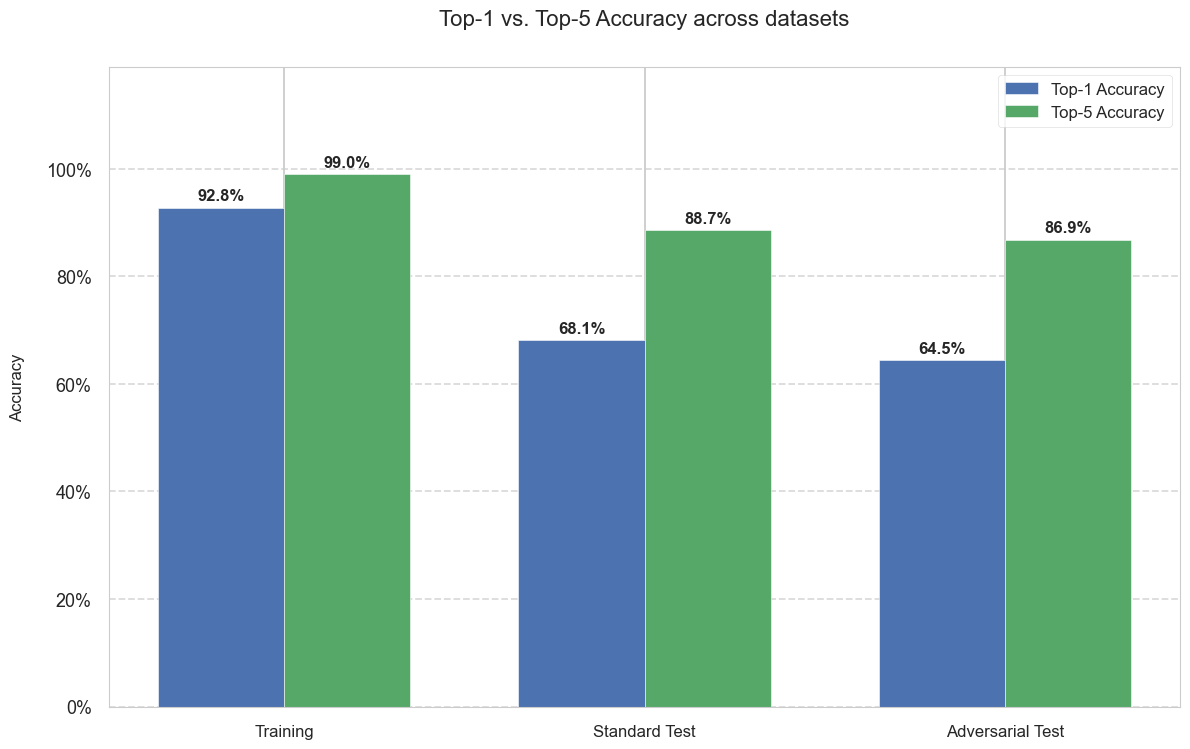

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import seaborn as sns
import numpy as np

sns.set_style("whitegrid")
plt.style.use('seaborn-v0_8-talk')

# Grouped data
labels = ['Training', 'Standard Test', 'Adversarial Test']
top1_accuracies = [train_acc, test_acc, adv_acc]
top5_accuracies = [train_top5, test_top5, adv_top5]

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

# Create Plot
fig, ax = plt.subplots(figsize=(12, 8))

# Plot bars for Top-1 and Top-5 accuracy
rects1 = ax.bar(x - width/2, top1_accuracies, width, label='Top-1 Accuracy', color='#4c72b0', zorder=2)
rects2 = ax.bar(x + width/2, top5_accuracies, width, label='Top-5 Accuracy', color='#55a868', zorder=2)

# A helper function to attach a text label above each bar
def add_labels(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.1%}', # Format as percentage with 1 decimal place
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=12, fontweight='bold')

add_labels(rects1)
add_labels(rects2)

# Set a clear title
ax.set_title('Top-1 vs. Top-5 Accuracy across datasets', fontsize=16, pad=30)

# Set y-axis label and limits
ax.set_ylabel('Accuracy', fontsize=12, labelpad=15)
ax.set_ylim(0, 1.19)

# Format the y-axis to show percentages directly
ax.yaxis.set_major_formatter(mticker.PercentFormatter(xmax=1.0))

# Set the x-axis ticks and labels
ax.set_xticks(x)
ax.set_xticklabels(labels, fontsize=12)

# Add a light horizontal grid for easier value reading
ax.grid(axis='y', linestyle='--', alpha=0.7)

# Add a legend to differentiate the bars
ax.legend(fontsize=12)

# Adjust layout to prevent labels from being cut off
plt.tight_layout(rect=[0, 0, 1, 0.95])

plt.show()

Labels fetched...
Running confusion matrix for standard test

Computing model predictions...

 Overall Performance Metrics
Macro Precision: 0.6856
Macro Recall:    0.6817
Macro F1-Score:  0.6768
Identifying the top 10 most misclassified classes...
Class: velvet               | Misclassified: 30/33   | Accuracy: 9.1%
Class: sunscreen            | Misclassified: 24/27   | Accuracy: 11.1%
Class: chiffonier           | Misclassified: 23/32   | Accuracy: 28.1%
Class: sunglasses           | Misclassified: 23/27   | Accuracy: 14.8%
Class: cloak                | Misclassified: 22/26   | Accuracy: 15.4%
Class: bakery               | Misclassified: 22/25   | Accuracy: 12.0%
Class: night_snake          | Misclassified: 22/30   | Accuracy: 26.7%
Class: cassette_player      | Misclassified: 21/23   | Accuracy: 8.7%
Class: laptop               | Misclassified: 21/24   | Accuracy: 12.5%
Class: tiger_cat            | Misclassified: 20/27   | Accuracy: 25.9%


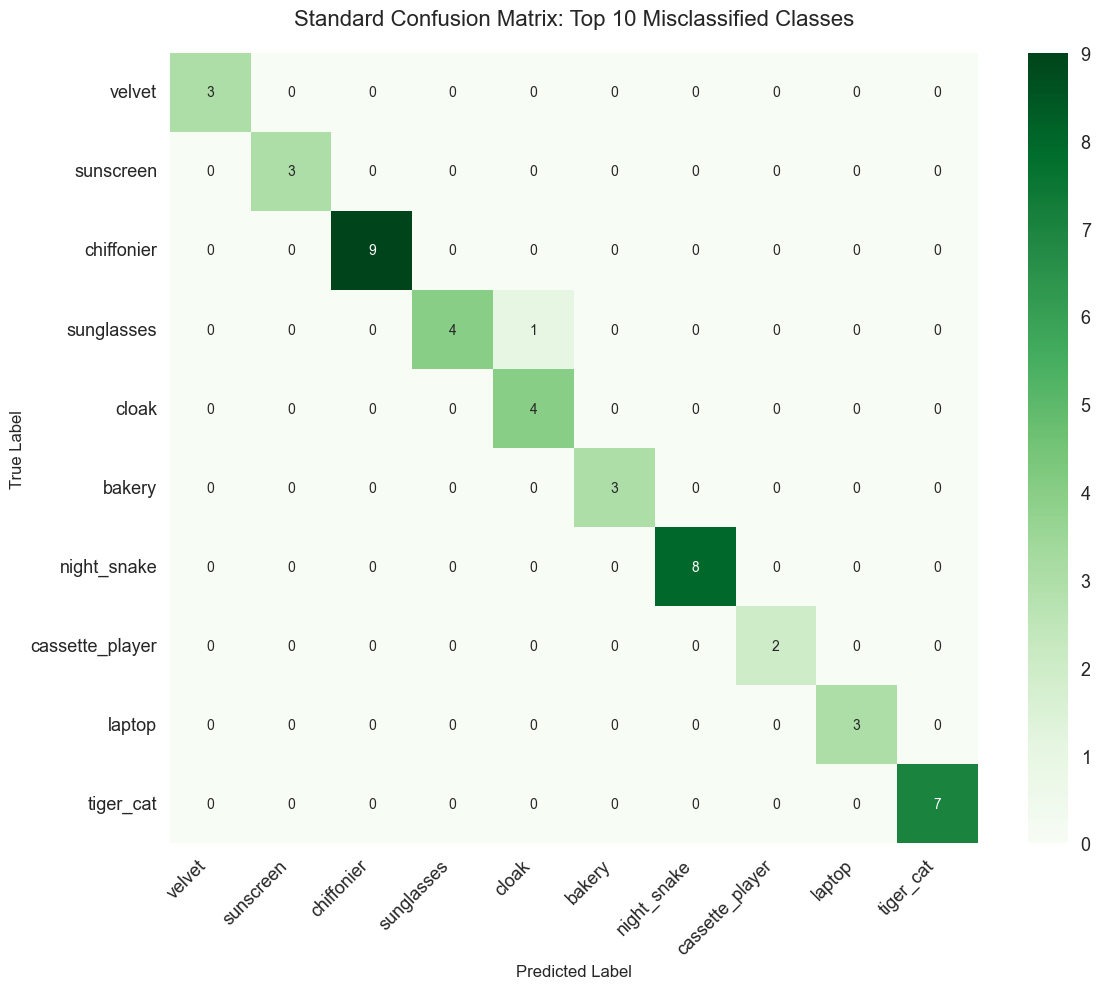

Running confusion matrix for adversarial test

Computing model predictions...


/Users/stanleyokwii/Documents/Birkbeck/Msc Project/msc-project-source-code-files-24-25-Stanley-Okwii/.venv/lib/python3.12/site-packages/keras/src/trainers/epoch_iterator.py:164: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



 Overall Performance Metrics
Macro Precision: 0.6497
Macro Recall:    0.6454
Macro F1-Score:  0.6406
Analyzing performance on a pre-defined set of 10 classes...
Class: velvet               | Misclassified: 30/33   | Accuracy: 9.1%
Class: sunscreen            | Misclassified: 24/27   | Accuracy: 11.1%
Class: chiffonier           | Misclassified: 25/32   | Accuracy: 21.9%
Class: sunglasses           | Misclassified: 23/27   | Accuracy: 14.8%
Class: cloak                | Misclassified: 23/26   | Accuracy: 11.5%
Class: bakery               | Misclassified: 22/25   | Accuracy: 12.0%
Class: night_snake          | Misclassified: 22/30   | Accuracy: 26.7%
Class: cassette_player      | Misclassified: 21/23   | Accuracy: 8.7%
Class: laptop               | Misclassified: 21/24   | Accuracy: 12.5%
Class: tiger_cat            | Misclassified: 20/27   | Accuracy: 25.9%


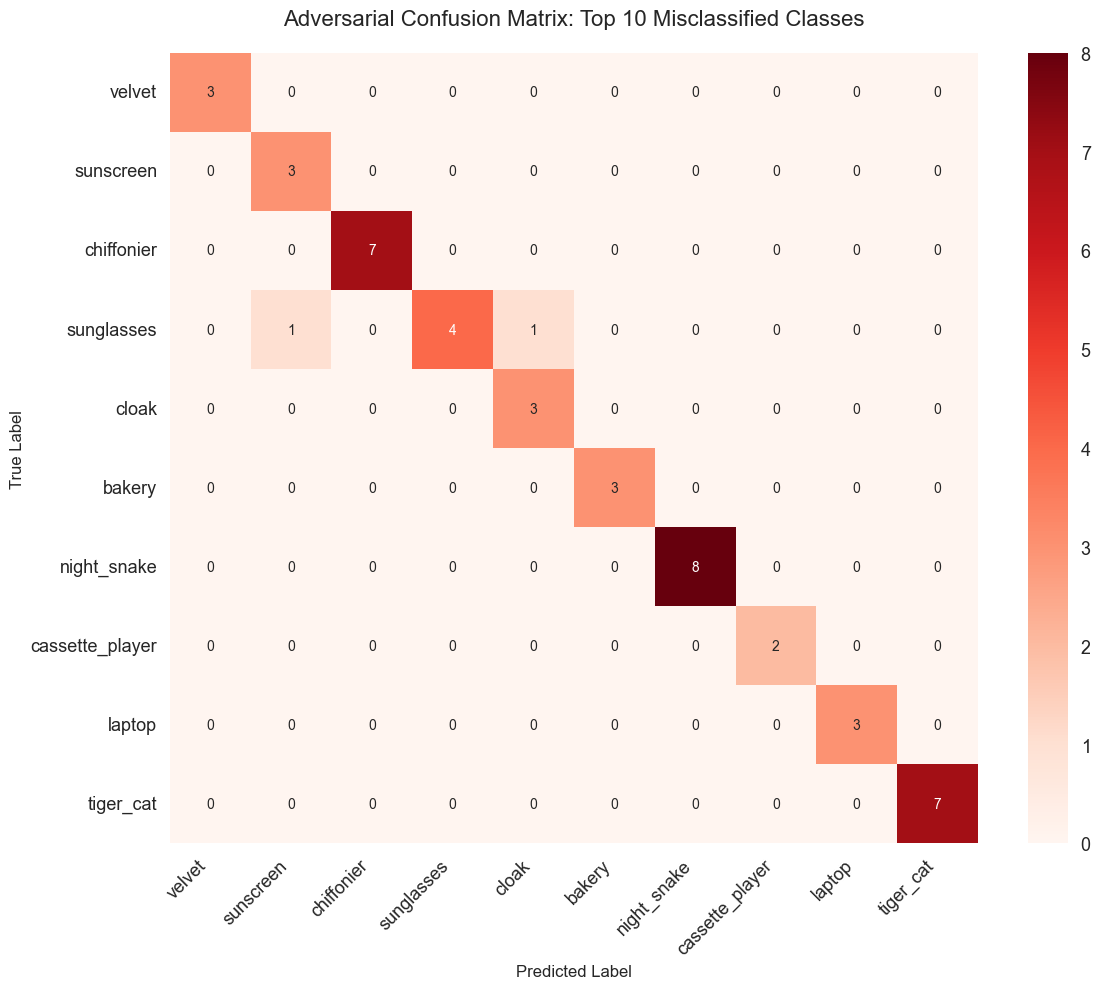

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import requests
import json



def get_imagenet_readable_labels():
    """
    Fetches the 1000 ImageNet class labels.
    Returns a list of class names or None if fetching fails.
    """
    url = "https://storage.googleapis.com/download.tensorflow.org/data/imagenet_class_index.json"
    
    try:
        response = requests.get(url)
        response.raise_for_status()

        # The JSON is a dictionary like: {"0": ["n01440764", "tench"], ...}
        class_data = response.json()
        
        class_names = [class_data[str(i)][1] for i in range(len(class_data))]

        print("Labels fetched...")
        return class_names

    except requests.exceptions.RequestException as e:
        print(f"Error fetching labels: {e}")
        return None


# Fetch the class labels once
class_names = get_imagenet_readable_labels()


def plot_misclassified_cm(model, dataset, class_names, k=10, use_class_names=None):
    """
    Plots a confusion matrix for the top-k most misclassified classes.

    Args:
        model: The trained model to evaluate.
        dataset: The dataset to evaluate on.
        class_names: A list of all possible class names.
        k (int): The number of top classes to display.
        use_class_names (list, optional): If provided, the plot will use this
            exact list of class names instead of calculating the top-k from the
            current dataset. This is useful for comparing performance on the
            same subset of classes across different datasets (e.g., standard vs. adversarial).

    Returns:
        list: The list of the top-k misclassified class names found in the dataset.
              Returns None if use_class_names was provided.
    """
    if not class_names:
        print("Cannot generate plot without class names.")
        return

    print("\nComputing model predictions...")
    y_true = np.concatenate([y.numpy() for _, y in dataset], axis=0)
    y_pred_proba = model.predict(dataset, verbose=0)
    y_pred_classes = np.argmax(y_pred_proba, axis=1)

    # --- Calculate the full confusion matrix ---
    cm = confusion_matrix(y_true, y_pred_classes, labels=np.arange(len(class_names)))

    print("\n Overall Performance Metrics")
    report = classification_report(y_true, y_pred_classes, output_dict=True, zero_division=0)
    macro_avg = report['macro avg']
    print(f"Macro Precision: {macro_avg['precision']:.4f}")
    print(f"Macro Recall:    {macro_avg['recall']:.4f}")
    print(f"Macro F1-Score:  {macro_avg['f1-score']:.4f}")

    # --- Determine which classes to plot ---
    if use_class_names is None:
        # This is the "discovery" mode: find the top-k misclassified classes
        print(f"Identifying the top {k} most misclassified classes...")
        misclassification_counts = cm.sum(axis=1) - np.diag(cm)
        top_k_indices = np.argsort(misclassification_counts)[-k:][::-1]
        
        # Get the names for the identified classes
        plot_class_names = [class_names[i] for i in top_k_indices]
        
        color_map = 'Greens'
        heatmap_title = 'Standard'

        for i in top_k_indices:
            total_samples = cm.sum(axis=1)[i]
            accuracy = (np.diag(cm)[i] / total_samples) if total_samples > 0 else 0
            print(f"Class: {class_names[i]:<20s} | Misclassified: {misclassification_counts[i]}/{total_samples:<4} | Accuracy: {accuracy:.1%}")

        return_value = plot_class_names # We will return the names we found
    else:
        # This is the "comparison" mode: use the provided class names
        print(f"Analyzing performance on a pre-defined set of {len(use_class_names)} classes...")
        plot_class_names = use_class_names
        
        # Find the indices corresponding to the provided class names
        class_to_idx = {name: i for i, name in enumerate(class_names)}
        top_k_indices = [class_to_idx[name] for name in plot_class_names if name in class_to_idx]
        
        color_map = 'Reds'
        heatmap_title = 'Adversarial'

        misclassification_counts = cm.sum(axis=1) - np.diag(cm)
        for i in top_k_indices:
            total_samples = cm.sum(axis=1)[i]
            accuracy = (np.diag(cm)[i] / total_samples) if total_samples > 0 else 0
            print(f"Class: {class_names[i]:<20s} | Misclassified: {misclassification_counts[i]}/{total_samples:<4} | Accuracy: {accuracy:.1%}")

        return_value = None # We don't need to return anything in this mode


    # Create the reduced confusion matrix for plotting
    cm_top_k = cm[np.ix_(top_k_indices, top_k_indices)]

    # Plot the heatmap
    plt.style.use('seaborn-v0_8-whitegrid')
    plt.figure(figsize=(12, 10))
    sns.heatmap(
        cm_top_k, annot=True, fmt='d', cmap=color_map,
        xticklabels=plot_class_names, yticklabels=plot_class_names
    )
    plt.title(f'{heatmap_title} Confusion Matrix: Top {k} Misclassified Classes', fontsize=16, pad=20)
    plt.ylabel('True Label', fontsize=12)
    plt.xlabel('Predicted Label', fontsize=12)
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()
    
    return return_value


print("Running confusion matrix for standard test")
# First call: Discover the top 10 misclassified classes on the standard test set
# and store the returned list of names in a variable.
top_10_misclassified_classes = plot_misclassified_cm(robust_model, test_dataset, class_names, k=10)

print("Running confusion matrix for adversarial test")
# Second call: Pass the list from the first run to the `use_class_names` parameter.
if top_10_misclassified_classes:
    plot_misclassified_cm(robust_model, adv_test_dataset, class_names, k=10, use_class_names=top_10_misclassified_classes)